# Agrupamiento conocido: Densidad Mean-shift

### Librerias

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import make_blobs


### Carga de datos


In [9]:
#Carga de datos
np.random.seed(31) # Fijamos una semilla para asegurar la reproducibilidad de la práctica
data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_cuatro_diferente_densidad.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
# Valores de la clase
Dy = D[:,2]

### Descripción de los datos cargados

El dataset cargado tiene 1999 instancias.
 
Matriz original D:  [[ 51.72   5.     2.  ]
 [ 47.93   5.     2.  ]
 [220.39   7.     3.  ]
 ...
 [ 30.15   6.     2.  ]
 [ 49.9    6.     2.  ]
 [ 40.66   7.     2.  ]]
 
Matriz sin los valores de la clase:  [[ 51.72   5.  ]
 [ 47.93   5.  ]
 [220.39   7.  ]
 ...
 [ 30.15   6.  ]
 [ 49.9    6.  ]
 [ 40.66   7.  ]]
 
Matriz de los valores de la clase:  [2. 2. 3. ... 2. 2. 2.]


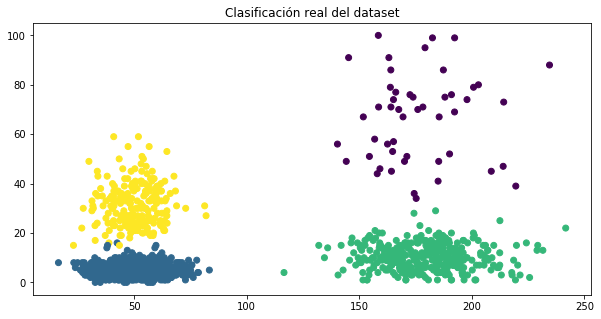

In [10]:
print('El dataset cargado tiene',Dy.size,'instancias.')
print(' ')
print ('Matriz original D: ', D)
print(' ')
print ('Matriz sin los valores de la clase: ', Dx)
print(' ')
print ('Matriz de los valores de la clase: ',  Dy)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)
ax.set_title('Clasificación real del dataset')
fig.text=''


### Funciones

In [11]:
def kernel_gaussiano(mDistancia, i, h):
    dist = mDistancia[i,:]
    dist = np.exp(-(dist / h)**2)
    # Solo se aceptan los que estén en el vecindario
    dist[dist <= (1.0 / np.e)] = 0

    return dist

def agrupamiento_densidad_MeanShift(Dx, h, n_iteraciones = 100):
    Dx_hist = []
    Dx_hist.append(Dx)
    actDx = np.copy(Dx)
    for it in np.arange(n_iteraciones):
        mDistancia = euclidean_distances(actDx)

        for i in np.arange(actDx.shape[0]):

            weights = kernel_gaussiano(mDistancia, i, h)
            weights.shape = (mDistancia.shape[0], 1)
            numerador = np.sum(weights*actDx, axis=0)
            denominador = np.sum(weights)
            Xp = numerador / denominador

            actDx[i,:] = Xp
        
        Dx_hist.append(np.copy(actDx))
        
        if np.allclose(Dx_hist[it], Dx_hist[it+1]):
            break

    centros = np.unique(np.round(Dx_hist[len(Dx_hist)-1],3), axis=0)
    asignacion = np.argmin(euclidean_distances(Dx_hist[len(Dx_hist)-1], centros),axis=1)

    return [ Dx_hist , centros, asignacion]

### Ejecución del algoritmo

In [12]:
[Dx_hist, centros, Dyp1] = agrupamiento_densidad_MeanShift(Dx, h=1)
[Dx_hist, centros, Dyp2] = agrupamiento_densidad_MeanShift(Dx, h=10)
[Dx_hist, centros, Dyp3] = agrupamiento_densidad_MeanShift(Dx, h=20)
[Dx_hist, centros, Dyp4] = agrupamiento_densidad_MeanShift(Dx, h=30)
[Dx_hist, centros, Dyp5] = agrupamiento_densidad_MeanShift(Dx, h=40)

### Comparación de resultados estimados con valores reales

Text(0.5,1,'Clasificación con h=40')

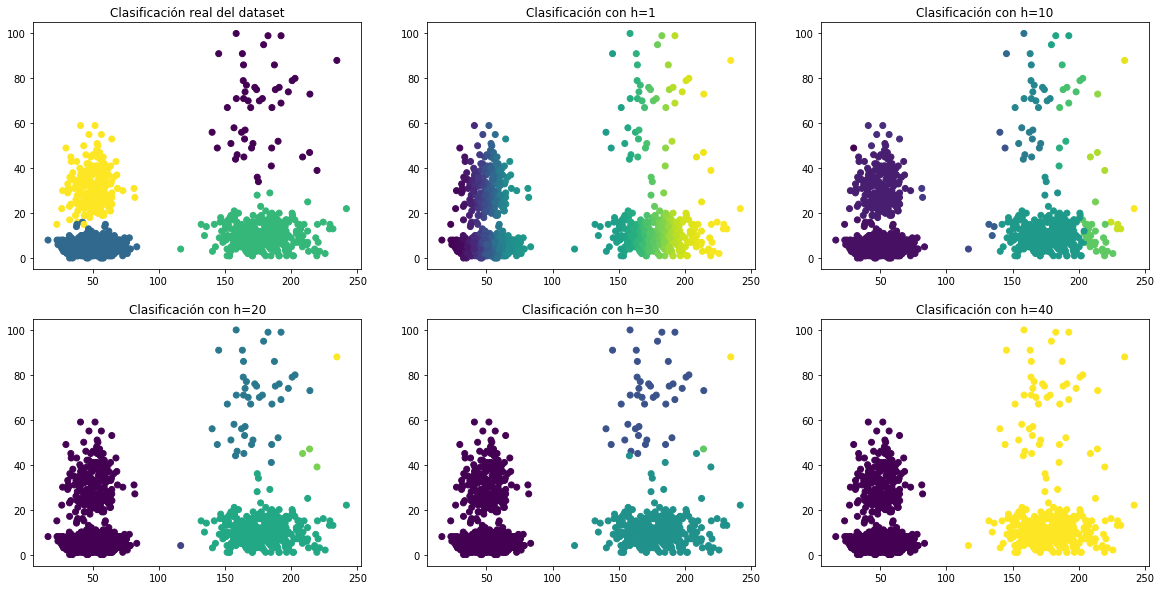

In [6]:
fig, ax = plt.subplots(2,3,figsize=(20,10))
fig.text=''
ax[0,0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[0,0].set_title('Clasificación real del dataset')
ax[0,1].scatter(Dx[:,0], Dx[:,1], c = Dyp1)
ax[0,1].set_title('Clasificación con h=1')
ax[0,2].scatter(Dx[:,0], Dx[:,1], c = Dyp2)
ax[0,2].set_title('Clasificación con h=10')
ax[1,0].scatter(Dx[:,0], Dx[:,1], c = Dyp3)
ax[1,0].set_title('Clasificación con h=20')
ax[1,1].scatter(Dx[:,0], Dx[:,1], c = Dyp4)
ax[1,1].set_title('Clasificación con h=30')
ax[1,2].scatter(Dx[:,0], Dx[:,1], c = Dyp5)
ax[1,2].set_title('Clasificación con h=40')

Se puede observar que no parece haber valores de <b>h</b> que aproximen el resultado al clustering real (4). El mejor agrupamiento obtenido con el algoritmo es el correspondiente a h=40.

### Métricas

In [7]:
def medida_R_cuadrado(X, Xyp, cXs):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp))
    sumTotal = np.sum(np.sum(X-cXglob,1)**2) 
    interior = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
   
    return interior/sumTotal

def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j])) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([totales[k] * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

mC = matriz_confusion(Dy,Dyp1)
print('Métricas para h=1:')
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))
print('El valor F1 es = ', medida_f1(mC))
print()

mC = matriz_confusion(Dy,Dyp2)
print('Métricas para h=10:')
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))
print('El valor F1 es = ', medida_f1(mC))
print()

mC = matriz_confusion(Dy,Dyp3)
print('Métricas para h=20:')
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))
print('El valor F1 es = ', medida_f1(mC))
print()

mC = matriz_confusion(Dy,Dyp4)
print('Métricas para h=30:')
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))
print('El valor F1 es = ', medida_f1(mC))
print()

mC = matriz_confusion(Dy,Dyp5)
print('Métricas para h=40:')
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))
print('El valor F1 es = ', medida_f1(mC))

Métricas para h=1:
El valor del error cometido es =  0.9709854927463731
La pureza del agrupamiento obtenido es =  0.9999999999999998
El valor F1 es =  0.05626491399500006

Métricas para h=10:
El valor del error cometido es =  0.04452226113056523
La pureza del agrupamiento obtenido es =  0.9969984992496248
El valor F1 es =  0.9711270400522749

Métricas para h=20:
El valor del error cometido es =  0.0035017508754376925
La pureza del agrupamiento obtenido es =  0.8934467233616809
El valor F1 es =  0.8675803200386308

Métricas para h=30:
El valor del error cometido es =  0.004002001000500299
La pureza del agrupamiento obtenido es =  0.8914457228614308
El valor F1 es =  0.866261520679856

Métricas para h=40:
El valor del error cometido es =  0.0
La pureza del agrupamiento obtenido es =  0.869934967483742
El valor F1 es =  0.8393806756910955
